# Decistion Transformer on HalfCheetah

A working example to which we can refer

In [2]:
import os
import random
from dataclasses import dataclass

import numpy as np
import torch
from datasets import load_dataset
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

/Users/lubiluk/Code/cldt/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the dataset from HF

In [3]:
os.environ["WANDB_DISABLED"] = "true" # we diable weights and biases logging for this tutorial
dataset = load_dataset("edbeeching/decision_transformer_gym_replay", "halfcheetah-expert-v2")
print(dataset["train"][0].keys())

dict_keys(['observations', 'actions', 'rewards', 'dones'])


## Defining a custom DataCollator

Decision transformer needs some dataset preprocessing. We use a HF collator mechanism to encapsulate that.

* Normalize each feature by subtracting the mean and dividing by the standard deviation.
* Pre-compute discounted returns for each trajectory.
* Scale the rewards and returns by a factor of 1000.
* Augment the dataset sampling distribution so it takes into account the length of the expert agent’s trajectories.


In [3]:
@dataclass
class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 20 #subsets of the episode we use for training
    state_dim: int = 17  # size of state space
    act_dim: int = 6  # size of action space
    max_ep_len: int = 1000 # max episode length in the dataset
    scale: float = 1000.0  # normalization of rewards/returns
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:
        self.act_dim = len(dataset[0]["actions"][0])
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        # calculate dataset stats for normalization of states
        states = []
        traj_lens = []
        for obs in dataset["observations"]:
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
        
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(
            np.arange(self.n_traj),
            size=batch_size,
            replace=True,
            p=self.p_sample,  # reweights so we sample according to timesteps
        )
        # a batch of dataset features
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            # for feature in features:
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature["rewards"]) - 1)

            # get sequences from dataset
            s.append(np.array(feature["observations"][si : si + self.max_len]).reshape(1, -1, self.state_dim))
            a.append(np.array(feature["actions"][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature["rewards"][si : si + self.max_len]).reshape(1, -1, 1))

            d.append(np.array(feature["dones"][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature["rewards"][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state + reward normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        }

## Extending the Decision Transformer to include a loss function

In order to be trained the DT needs to return loss from it's forward method. Why doesn't it do it out of the box?

In [4]:
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        
        loss = torch.mean((action_preds - action_targets) ** 2)

        return {"loss": loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

## Defining the training hyperparameters

Config can be further tweaked

In [13]:
collator = DecisionTransformerGymDataCollator(dataset["train"])
config = DecisionTransformerConfig(state_dim=collator.state_dim, act_dim=collator.act_dim)
model = TrainableDT(config)

In [6]:
training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=20,
    per_device_train_batch_size=64,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    data_collator=collator,
)

trainer.train()

/home/lubiluk/Code/cldt/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


100%|██████████| 320/320 [10:42<00:00,  2.01s/it]

{'train_runtime': 642.5256, 'train_samples_per_second': 31.127, 'train_steps_per_second': 0.498, 'train_loss': 0.13903520107269288, 'epoch': 20.0}


TrainOutput(global_step=320, training_loss=0.13903520107269288, metrics={'train_runtime': 642.5256, 'train_samples_per_second': 31.127, 'train_steps_per_second': 0.498, 'total_flos': 24556704000000.0, 'train_loss': 0.13903520107269288, 'epoch': 20.0})

## Visualize the performance of the agent

There is a nice trick with displaying renders in jupyter.

The DT was trained on ChalfCheetah-v2 but we run v4 here. It's compatible but it uses gymnasium new interface.

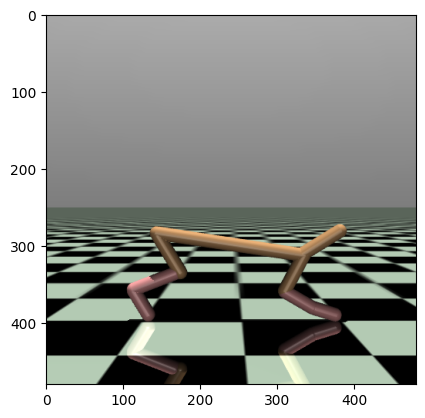

In [9]:
import mujoco
import gymnasium as gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


# Function that gets an action from the model using autoregressive prediction with a window of the previous 20 timesteps.
def get_action(model, states, actions, rewards, returns_to_go, timesteps):
    # This implementation does not condition on past rewards

    states = states.reshape(1, -1, model.config.state_dim)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    states = states[:, -model.config.max_length :]
    actions = actions[:, -model.config.max_length :]
    returns_to_go = returns_to_go[:, -model.config.max_length :]
    timesteps = timesteps[:, -model.config.max_length :]
    padding = model.config.max_length - states.shape[1]
    # pad all tokens to sequence length
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)
    states = torch.cat([torch.zeros((1, padding, model.config.state_dim)), states], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, model.config.act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )

    return action_preds[0, -1]
     


env = gym.make("HalfCheetah-v4", render_mode='rgb_array')
max_ep_len = 10
device = "cpu"
scale = 1000.0  # normalization for rewards/returns
TARGET_RETURN = 12000 / scale  # evaluation is conditioned on a return of 12000, scaled accordingly

state_mean = collator.state_mean.astype(np.float32)
state_std = collator.state_std.astype(np.float32)
print(state_mean)

state_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
# Create the decision transformer model

state_mean = torch.from_numpy(state_mean).to(device=device)
state_std = torch.from_numpy(state_std).to(device=device)


# Interact with the environment and create a video
episode_return, episode_length = 0, 0
state, _ = env.reset()
target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
rewards = torch.zeros(0, device=device, dtype=torch.float32)

img = plt.imshow(env.render()) # only call this once

timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
for t in range(max_ep_len):
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
    rewards = torch.cat([rewards, torch.zeros(1, device=device)])

    action = get_action(
        model,
        (states - state_mean) / state_std,
        actions,
        rewards,
        target_return,
        timesteps,
    )
    actions[-1] = action
    action = action.detach().cpu().numpy()

    state, reward, ter, tru, _ = env.step(action)
    done = ter or tru

    cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
    states = torch.cat([states, cur_state], dim=0)
    rewards[-1] = reward

    pred_return = target_return[0, -1] - (reward / scale)
    target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
    timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

    episode_return += reward
    episode_length += 1

    if done:
        break


In [10]:
pt_save_directory = "../models/dt_hc"
model.save_pretrained(pt_save_directory)